In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
import time
import numpy as np
import io
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import threading
import torchvision.models as models
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
from nltk.corpus import wordnet
from caption_transforms import SimCLRData_Caption_Transform
from image_transforms import SimCLRData_image_Transform
from dataset import FlickrDataset
from models import ResNetSimCLR,OpenAI_SIMCLR
from utils import get_gpu_stats,layerwise_trainable_parameters,count_trainable_parameters
from metrics import ContrastiveLoss
from metrics import LARS,Optimizer_simclr
from logger import Logger
from train_fns import train, test


In [2]:
get_gpu_stats()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize trial number
trial_number = 2
projection_dim=128
#encoder_last_layer=2048
image_learning_rate = 0.03
text_learning_rate=0.0005
momentum = 0.9
temperature = 0.07
weight_decay = 0.0001
optimizer_type = 'sgd'
total_epochs=100
trade_off_ii=1
trade_off_cc=1
trade_off_ic=0.0001
trade_off_ci=0.0001

cuda
No of GPUs i have is 2
0
My Graphic Card is Tesla V100-PCIE-16GB
Is Cuda Available True


In [ ]:
random.seed(42)

# Set the seed for PyTorch's random number generator
torch.manual_seed(42)

# Create train and test datasets using FlickrDataset
train_dataset = FlickrDataset('data/', "data/train", 'train',
                              image_transform=SimCLRData_image_Transform(),
                              caption_transform=SimCLRData_Caption_Transform())

test_dataset = FlickrDataset('data/', "data/test", 'test',
                             image_transform=SimCLRData_image_Transform(),
                             caption_transform=SimCLRData_Caption_Transform())

# Set the batch size and create train and test data loaders
batch_size = 128
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          pin_memory=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=4, 
                         pin_memory=True)
# Set device to CUDA if available, otherwise to CPU

# Initialize ResNetSimCLR model
model_resnet = ResNetSimCLR(
    model='resnet50',
    projection_dim=projection_dim,
    layers_to_train=['layer3','layer4'],
).to(device)

# Print total number of trainable parameters of ResNetSimCLR model

# Initialize OpenAI_SIMCLR model
gpt_model = OpenAI_SIMCLR(
    model='openai-gpt',
    projection_dim=projection_dim,
    layers_to_train=['h.10','h.11'],
).to(device)

# Define loss function
NXTENT_loss = ContrastiveLoss(device, temperature=temperature)

# Define optimizers and schedulers
optimizer_image = Optimizer_simclr(optimizer_name=optimizer_type,
                                   model_parameters=model_resnet.parameters(),
                                   lr=image_learning_rate,
                                   momentum=momentum,
                                   weight_decay=weight_decay)

scheduler_image = optimizer_image.scheduler
optimizer_image = optimizer_image.optimizer

optimizer_text = Optimizer_simclr(optimizer_name=optimizer_type,
                                  model_parameters=gpt_model.parameters(),
                                  lr=text_learning_rate,
                                  momentum=momentum,
                                  weight_decay=weight_decay)

scheduler_text = optimizer_text.scheduler
optimizer_text = optimizer_text.optimizer

# Define paths for logs and files
log_dir = os.path.join(os.getenv('WORK'), 'cv_project')
image_caption_filename = os.path.join(log_dir, 'image_caption')
train_log = os.path.join(image_caption_filename, f'train_{trial_number}.log')
image_model_log = os.path.join(image_caption_filename, f'image_model_{trial_number}.pth')
text_model_log = os.path.join(image_caption_filename, f'text_model_{trial_number}.pth')
graph_save_dir = '/home1/08629/pradhakr/cv_project/graphs/image_caption'

# Create a logger object and start training
logger_save = Logger(train_log,
                     image_model_log,
                     text_model_log, 
                     optimizer_type, 
                     image_learning_rate,
                     text_learning_rate,
                     weight_decay,
                     batch_size,
                     momentum, 
                     temperature, 
                     total_epochs,
                     trade_off_cc,
                     trade_off_ii,
                     trade_off_ic,
                     trade_off_ci,
                     'resnet50',
                     'openai-gpt',
                     ['layer3','layer4'],
                     ['h.10','h.11'],
                     projection_dim,
                     count_trainable_parameters(model_resnet),
                     count_trainable_parameters(gpt_model),
                    scheduler=True,
                    encoder_last_layer=None)
logger_save.start_training()

# Loop through epochs and train the models
for epoch in tqdm(range(total_epochs)):
    
    start = time.time()
    
    # Train the models and get the loss
    train_loss = train(dataloader=train_loader, 
                       image_model=model_resnet, 
                       text_model=gpt_model,
                       optimizer_image=optimizer_image, 
                       optimizer_text=optimizer_text, 
                       criterion=NXTENT_loss,
                        device=device,
                       scheduler_image=scheduler_image,
                       scheduler_text=scheduler_text,
                       trade_off_ii=trade_off_ii, 
                       trade_off_cc=trade_off_cc,
                       trade_off_ic=trade_off_ic,
                       trade_off_ci=trade_off_ci)
    
    # Test the models and get the loss
    test_loss = test(dataloader=test_loader, 
                     image_model=model_resnet,
                     text_model=gpt_model,
                     criterion=NXTENT_loss,
                     device=device,
                     trade_off_ii=trade_off_ii,
                     trade_off_cc=trade_off_cc,
                     trade_off_ic=trade_off_ic,
                     trade_off_ci=trade_off_ci)
    
    end = time.time()
    
    # Log the results of the epoch
    logger_save.log(epoch + 1, model_resnet, gpt_model, train_loss, test_loss, end - start)

# End training and plot the losses
logger_save.end_training()
logger_save.plot_losses(trial_number,
                        graph_save_dir,
                        optimizer_type, 
                        image_learning_rate,
                        text_learning_rate,
                        weight_decay, 
                        batch_size, 
                        momentum, 
                        temperature, 
                       total_epochs,
                        trade_off_cc,
                        trade_off_ii,
                        trade_off_ci,
                        trade_off_ic,
                       'resnet50',
                        'openai-gpt',
                        ['layer3','layer4'],
                        ['h.10','h.11'],
                        projection_dim,
                        count_trainable_parameters(model_resnet),
                        count_trainable_parameters(gpt_model),
                      scheduler=True,
                    encoder_last_layer=None)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
 54%|█████▍    | 54/100 [1:09:08<59:24, 77.49s/it]  

In [16]:
resnet_model =model_resnet = ResNetSimCLR(
    model='resnet50',
    projection_dim=128,
    layers_to_train=['layer3','layer4']
).to(device)
weights_file='/work/08629/pradhakr/maverick2/cv_project/image_caption/image_model_2.pth'
resnet_model.load_state_dict(torch.load(weights_file))
resnet_model.eval()
resnet_model.projection_head=nn.Identity()

In [17]:
query_image_path ='/home1/08629/pradhakr/cv_project/data/test/52265719626_aebee6d6d7.jpg'
image = Image.open(query_image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

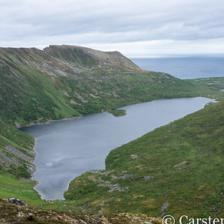

In [18]:
image

In [19]:
query_image = preprocess(image).unsqueeze(0)
with torch.no_grad():
    features,features = resnet_model(query_image,device)

In [ ]:
query_features = features.cpu().squeeze().numpy()
query_features.shape

In [ ]:
query_text = "A red car driving on a road"
with torch.no_grad():
    query_text_features, _ = gpt_model(query_text, device)
    query_text_features = query_text_features.cpu().squeeze().numpy()

In [26]:
similarities = []
image_paths = []
for root, dirs, files in os.walk('/home1/08629/pradhakr/cv_project/data/test'):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            image_tensor = preprocess(image).unsqueeze(0)
            with torch.no_grad():
                image_features,_ = resnet_model(image_tensor,device)
                image_features = image_features.cpu().squeeze().numpy()
            similarity = (np.dot(query_features, image_features) / (np.linalg.norm(query_features) * 
                                                                   np.linalg.norm(image_features)))
            similarities.append(similarity)
            image_paths.append(image_path)

In [27]:
k = 5
indices = np.argsort(similarities)[::-1][:k]
similar_images = [image_paths[i] for i in indices]

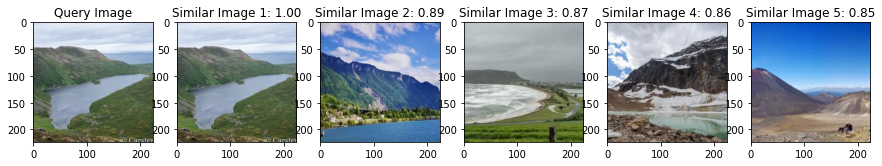

In [28]:
query_image = Image.open(query_image_path)
fig, axs = plt.subplots(1, k+1, figsize=(15, 15))
axs[0].imshow(query_image)
axs[0].set_title('Query Image')
for i, image_path in enumerate(similar_images):
    image = Image.open(image_path)
    similarity_score = similarities[indices[i]]
    axs[i+1].imshow(image)
    axs[i+1].set_title('Similar Image {}: {:.2f}'.format(i+1, similarity_score))

plt.show()

In [29]:
similarities

[0.48820332,
 0.6339033,
 0.6164089,
 0.65919805,
 0.56092167,
 0.6600164,
 0.60004264,
 0.62306714,
 0.66193944,
 0.59817743,
 0.5239348,
 0.6040617,
 0.57365215,
 0.5546955,
 0.613763,
 0.68056566,
 0.5552898,
 0.61397725,
 0.5845458,
 0.5916825,
 0.6181435,
 0.63293636,
 0.55280626,
 0.6375518,
 0.70046383,
 0.5311188,
 0.70323926,
 0.7378764,
 0.57207555,
 0.5792764,
 1.0,
 0.42833248,
 0.59509295,
 0.7632015,
 0.4782607,
 0.54679996,
 0.68100274,
 0.5234685,
 0.67348427,
 0.6015261,
 0.60963255,
 0.7439996,
 0.4543716,
 0.84062034,
 0.5693753,
 0.48078963,
 0.3912662,
 0.4446735,
 0.47318366,
 0.5233622,
 0.3863278,
 0.57017833,
 0.6774502,
 0.41529244,
 0.7562417,
 0.6531139,
 0.39193046,
 0.4140186,
 0.4591926,
 0.68106014,
 0.497254,
 0.7502942,
 0.39828688,
 0.4608574,
 0.3702176,
 0.52358365,
 0.6094433,
 0.6047971,
 0.38003927,
 0.65474933,
 0.5779156,
 0.4805731,
 0.5689826,
 0.51798964,
 0.6595978,
 0.3639061,
 0.45174125,
 0.48396587,
 0.3801688,
 0.40863538,
 0.3951704,
